In [33]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.ops import nms
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [34]:
images = sorted(os.listdir("SegData/Images"))
masks = sorted(os.listdir("SegData/Masks"))

In [35]:
idx = 0
img = Image.open("SegData/Images/" + images[idx]).convert("RGB")
mask = Image.open("SegData/Masks/" + masks[idx])

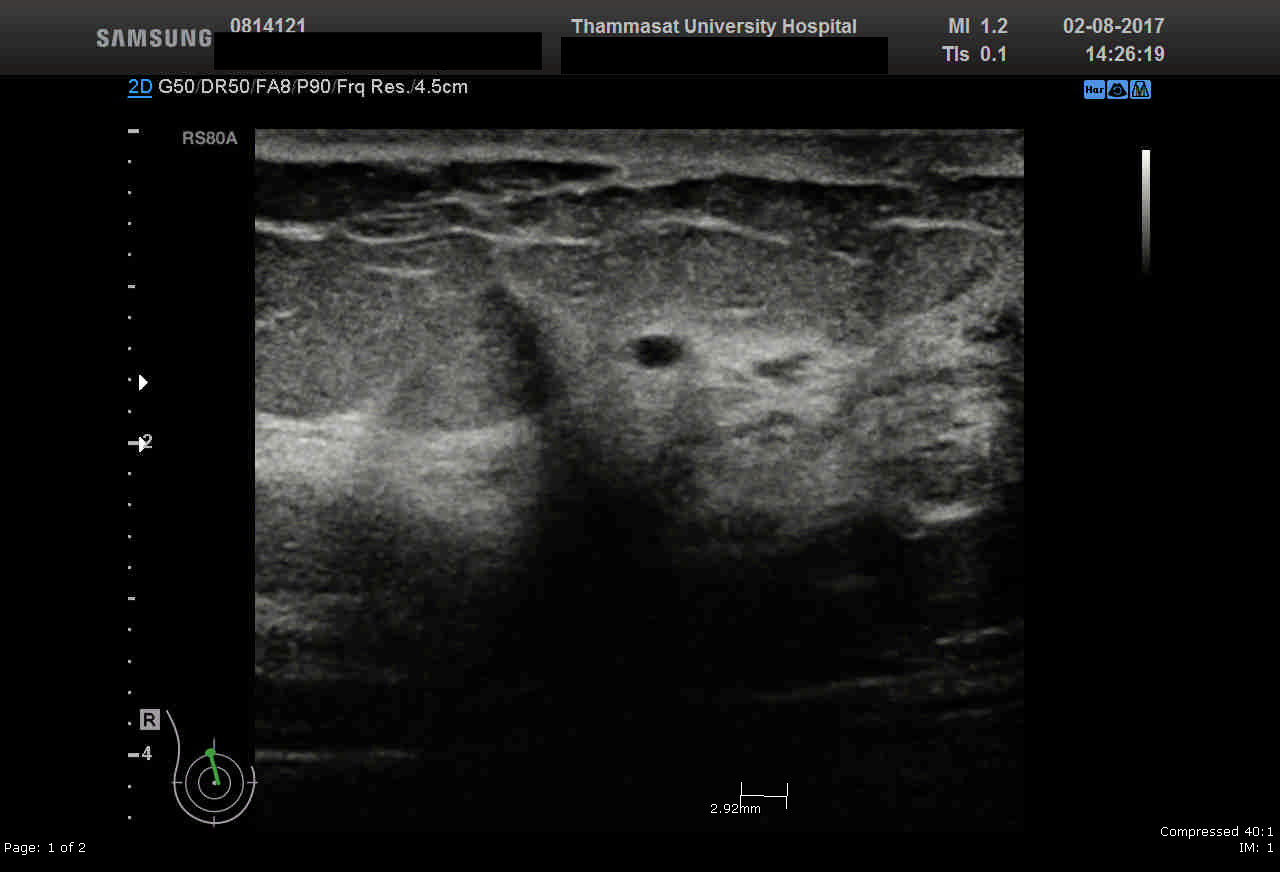

In [36]:
img

In [37]:
np.unique(mask)

array([False,  True])

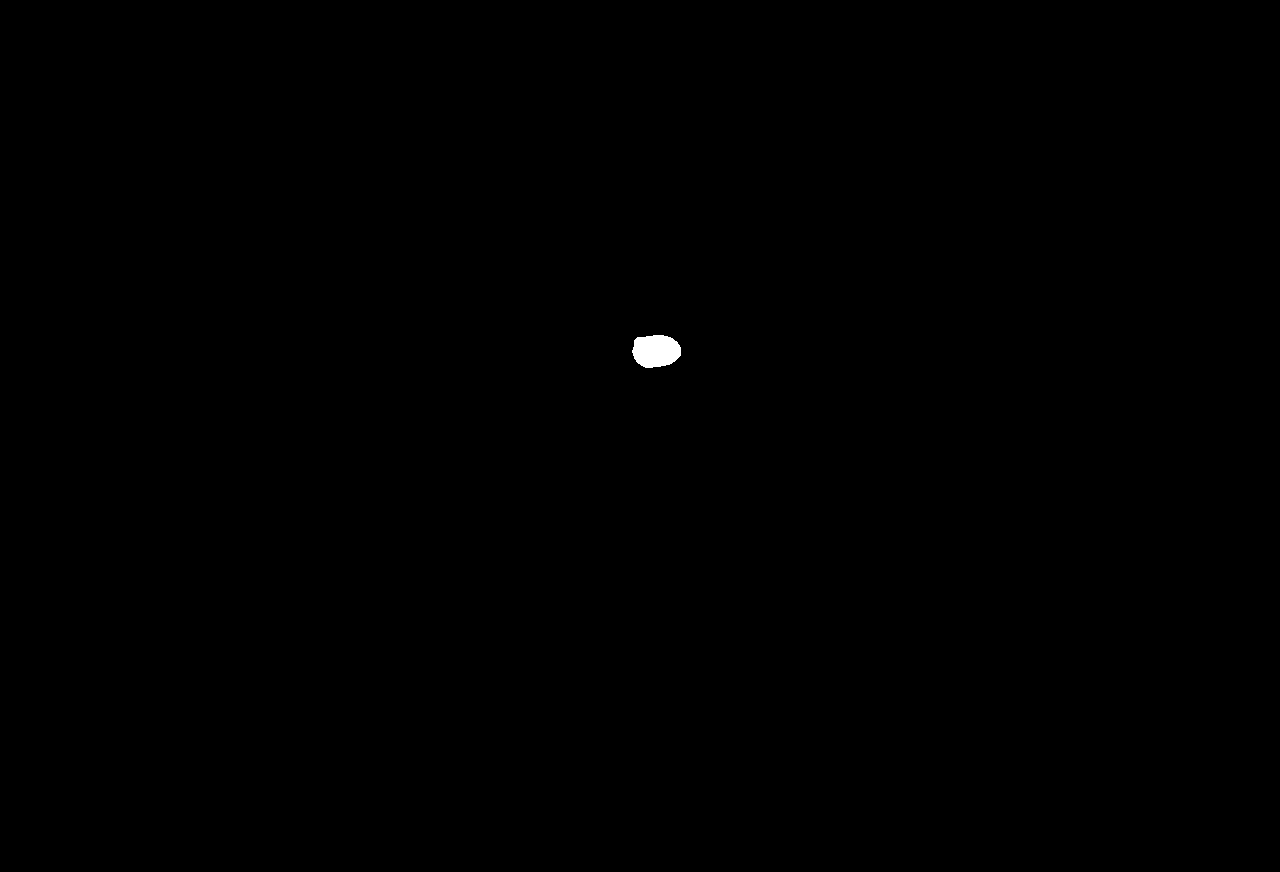

In [38]:
Image.fromarray(np.array(mask) == 1)

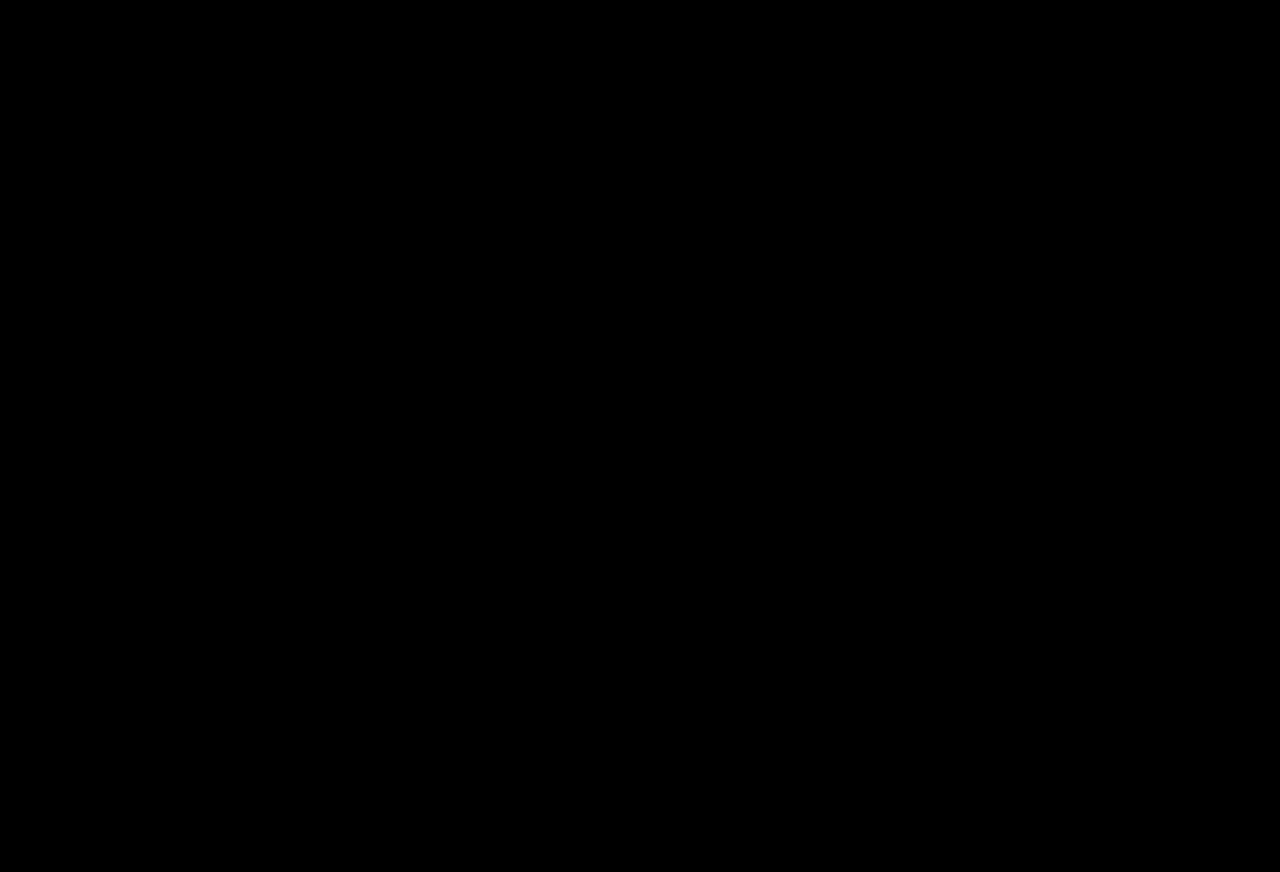

In [39]:
Image.fromarray(np.array(mask) == 2)

In [40]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks
        
    def __getitem__(self , idx):
        img = Image.open("SegData/Images/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("SegData/Masks/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target
    
    def __len__(self):
        return len(self.imgs)

In [41]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [42]:
transform = T.ToTensor()

In [43]:
def custom_collate(data):
  return data

In [44]:
images = sorted(os.listdir("SegData/Images"))
masks = sorted(os.listdir("SegData/Masks"))
num = int(0.75 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [45]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 0 , 
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) , 
                                 batch_size = 2 , 
                                 shuffle = True , 
                                 collate_fn = custom_collate , 
                                 num_workers = 0 , 
                                 pin_memory = True if torch.cuda.is_available() else False)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [48]:
params = [p for p in model.parameters() if p.requires_grad]

In [49]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [50]:
def calculate_iou(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two boxes.
    Box format: [x_min, y_min, x_max, y_max]
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    inter_x1 = max(x1, x1g)
    inter_y1 = max(y1, y1g)
    inter_x2 = min(x2, x2g)
    inter_y2 = min(y2, y2g)

    inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    # Compute the intersection over union
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou
def calculate_mAP(predictions, targets, iou_threshold=0.5):
    """
    Calculate the mean Average Precision (mAP).
    Args:
    - predictions: list of lists of predicted boxes, each box is a dictionary with 'boxes' and 'scores'
    - targets: list of lists of ground truth boxes, each box is a dictionary with 'boxes' and 'labels'
    - iou_threshold: IoU threshold to consider a prediction as a true positive
    """
    all_precisions = []
    all_recalls = []
    
    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()  # Predicted bounding boxes
        pred_scores = pred['scores'].cpu().numpy()  # Confidence scores
        target_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        
        # Sort predictions by confidence score (descending order)
        sorted_indices = pred_scores.argsort()[::-1]
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]
        
        tp = 0
        fp = 0
        fn = len(target_boxes)  # Number of ground truth boxes
        
        matched = []
        
        for i, pred_box in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            
            for j, gt_box in enumerate(target_boxes):
                if j not in matched:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_gt_idx = j
            
            if best_gt_idx != -1:
                tp += 1
                matched.append(best_gt_idx)
            else:
                fp += 1
        
        fn -= len(matched)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        all_precisions.append(precision)
        all_recalls.append(recall)
    
    # mAP is the mean of the precision values over all classes and images
    mAP = sum(all_precisions) / len(all_precisions) if all_precisions else 0
    return mAP


In [51]:
best_mAP=0.9208860759493671
all_train_losses = []
all_val_losses = []
flag = False

for epoch in range(30):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    
    # Training loop
    for i, dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device), dt[1][0].to(device)]
        targ = [dt[0][1], dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        
        loss = model(imgs, targets)
        if not flag:
            print(loss)
            flag = True
        
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    all_train_losses.append(train_epoch_loss)
    
    # Validation loop and mAP calculation
    val_predictions = []
    val_targets = []
    
    with torch.no_grad():
        for j, dt in enumerate(val_dl):
            model.eval()
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            
            # Get predictions from model
            predictions = model(imgs)
            
            # Append for mAP calculation
            val_predictions.extend(predictions)
            val_targets.extend(targets)

            model.train()
            # Calculate validation loss
            loss = model(imgs, targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        
        all_val_losses.append(val_epoch_loss)
        
        # mAP calculation (for IoU=0.5)
        mAP = calculate_mAP(val_predictions, val_targets, iou_threshold=0.5)
    
    # Print loss and mAP
    print(f"Epoch: {epoch}, Train Loss: {train_epoch_loss}, Val Loss: {val_epoch_loss}, Val mAP: {mAP}")

    if mAP > best_mAP:
        best_mAP = mAP
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"Saved best model at epoch {epoch} with mAP: {mAP}")

{'loss_classifier': tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.0763, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0003, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)}
Epoch: 0, Train Loss: 86.51803756505251, Val Loss: 28.47491966933012, Val mAP: 0.43832504520795645
Epoch: 1, Train Loss: 70.18510012328625, Val Loss: 23.364780485630035, Val mAP: 0.49212251356238673
Epoch: 2, Train Loss: 58.476315066218376, Val Loss: 32.16727760434151, Val mAP: 0.4931849005424952
Epoch: 3, Train Loss: 65.4455082938075, Val Loss: 26.788705244660378, Val mAP: 0.7127637130801692
Epoch: 4, Train Loss: 52.38978725671768, Val Loss: 23.473086193203926, Val mAP: 0.7920358649789034
Epoch: 5, Train Loss: 50.64995710551739, Val Loss: 22.6426423564

KeyboardInterrupt: 

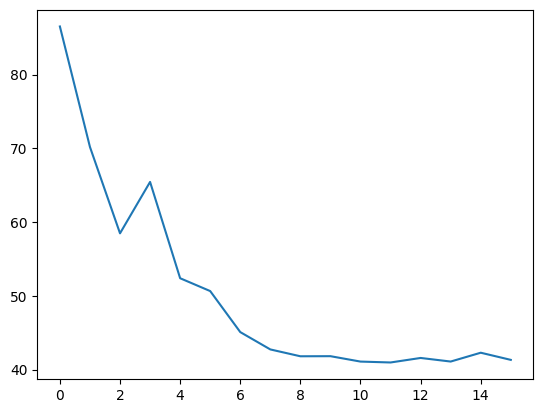

In [52]:
plt.plot(all_train_losses)

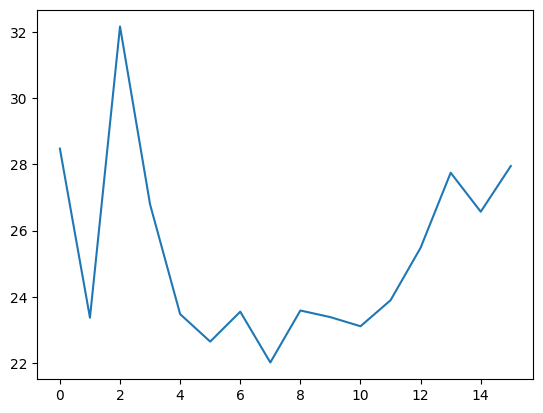

In [53]:
plt.plot(all_val_losses)

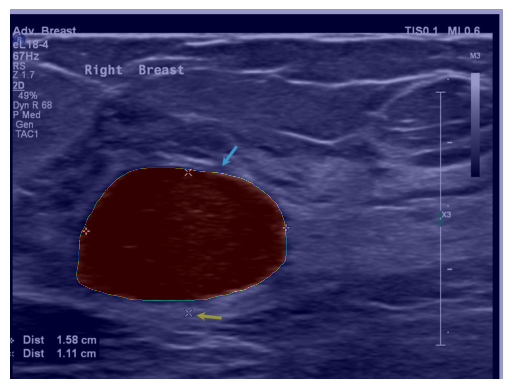

In [54]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

model.eval()
img = Image.open("test/parallel03a.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

# Convert predictions back to CPU and numpy
masks = pred[0]['masks'].cpu().detach().numpy()

# Select the first mask (you can loop through or use them all if needed)
mask = masks[0, 0]  # The first predicted mask, shape (H, W)

# Threshold the mask to make it binary (1 for mask, 0 for background)
mask_binary = mask > 0.5  # You can tweak this threshold

# Convert mask_binary to an uint8 format
mask_binary = mask_binary.astype(np.uint8)

# Plot the original image and overlay the mask
fig, ax = plt.subplots(1)

# Display the original image
ax.imshow(img)

# Overlay the mask with some transparency (alpha)
ax.imshow(mask_binary, cmap='jet', alpha=0.4)  # alpha controls transparency

plt.axis('off')  # Turn off axis labels
plt.show()
